# Combinatorial Optimization

Some optimization problems are ***combinatorial***, in the sense that there are $p$ items that can be ordered or combined in many different ways, some ways being better than others according to a set of specified criteria.

As an example, consider the deceptively simple traveling salesman problem (TSP), which attempts to optimize the hypothetical path of a salesman who is required to visit each of a set of cities once, then return home. Assuming travel is the same distance irrespective of travel direction, there are:

$$\frac{(p-1)!}{2}$$

possible routes. So, 5 cities have 12 possible routes, 10 cities have 181,440 routes, 50 cities have $3 \times 10^{64}$ routes!


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

sns.set(context='notebook', style='ticks', palette='viridis')

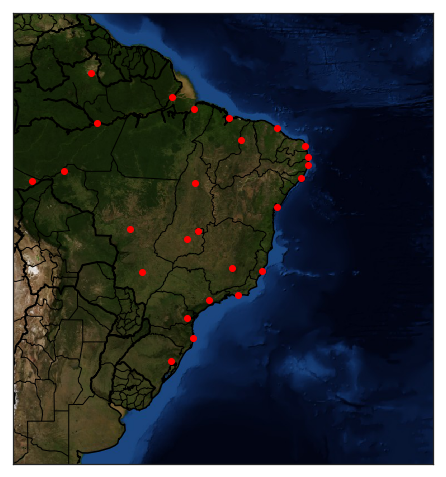

In [2]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('../data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

xmin, xmax, ymin, ymax = -70.0, -20.0, -40.0, 10.0

fig = plt.figure(figsize=(11.7,8.3))
bm = Basemap(projection='merc', \
             llcrnrlon=xmin, llcrnrlat=ymin, \
             urcrnrlon=xmax, urcrnrlat=ymax, \
             lon_0=0.5*(xmax + xmin), lat_0=0.5*(ymax + ymin), \
             resolution='l', area_thresh=1000000)
    
bm.drawcoastlines(linewidth=1.5)
bm.bluemarble()
bm.drawcountries(linewidth=2)
bm.drawstates(linewidth=1)

for i,c in cities.iterrows():
    bm.plot(-c['lat'], c['lon'], 'ro', latlon=True)

The difficulty of a problem of size $p$ can be quantified by ***the number of calculations needed to solve the worst-case scenario using the best available algorithm***.

We can bound the number of operations using the "Big-O" notation, which is a relative representation of the complexity of an algorithm. It can be used to compare similar tasks doing similar sorts of operations on similar data. 

So, in general we use the notation:

$$\mathcal{O}(h(p))$$

For example, if $h$ is polynomial in $p$, then the algorithm is polynomial.

Given what we showed above, the TSP is $\mathcal{O}(p!)$ or factorial complexity. If we were able to solve a 20-city problem in 1 minute using a particular algorithm, then we could solve:

* $p=21$ in 21 minutes
* $p=25$ in 12.1 years
* $p=30$ in 207 million years
* $p=50$ in $2.4 \times 10^{40}$ years

contrast this with a polynomial problem such as $\mathcal{O}(p^2)$:

* $p=21$ in 70 seconds
* $p=25$ in 1.57 minutes
* $p=30$ in 2.25 minutes
* $p=50$ in 6.25 minutes

Clearly, finding an algorithm that reduces solving a particular problem from factorial to polynomial time is advantageous.

![xkcd travelling salesman](http://imgs.xkcd.com/comics/travelling_salesman_problem.png)

(via [xkcd](http://xkcd.com/399/))

## Heuristics

Unfortunately, there is no known combinatorial optimization algorithm for obtaining an optimal solution to the TSP in polynomial time. Instead, we must turn to ***heuristics***, which have no guarantee of a global maximum, but in practice tend to yield *good* results in a reasonable time. Thus, we are trading off global optimality for a little speed.

Heuristics have two notable characteristics:

* **iteration**: candidate solutions are incrementally improved
* **localization**: search for improved solutions are restricted to a local neighborhood of the current solution

This ***local search*** approach encompasses several specific techniques, some of which we will explore here. For a given candidate solution vector $\mathbf{\theta}^{(t)}$ at iteration $t$, we might change components $\theta_i$ to propose an updated solution $\mathbf{\theta}^{(t+1)}$. Limiting the number of changes keeps $\mathbf{\theta}^{(t+1)}$ in the *neighborhood* of $\mathbf{\theta}^{(t)}$. We refer to $k$ changes to the candidate solution as a **k-change** and the set of possible new candidates as the *k-neighborhood*.

A sensible approach for updating a candidate solution is to choose the best candidate from the neighborhood; this is called ***steepest ascent***. The selection of any improved candidate is called an *ascent*. However, choosing the steepest ascent from a neighborhood may not be globally optimal if, for example, it takes us toward a local maximum at the cost of missing a global maximum. An algorithm that uses a steepest ascent strategy in the context of local search is called a *greedy* algorithm.

In order to attain a global maximum (or globally-competitive solution), it makes sense to  occasionaly choose an candidate solution that is not the best-in-neighborhood. In other words, to move from one peak to another (higher) peak, one must pass through valleys.

Since local search algorithms can easily converge to local optima, one *ad hoc* approach to improve exploration of the parameter space is to use ***random starts***. This simply involves running the local search multiple times, each time initializing the starting point randomly over $\Theta$.

### Example: Baseball salaries

Perhaps we wish to develop a predictive model of baseball salaries, using various player statistics as predictors. To keep things simple, we will use linear regression on everyday players (non-pitchers) only. We seek an optimal (parsimonious) subset of a set that includes 27 candidate statistics. 

A brute-force search of the entire parameter space would involve comparing $2^{27} = 134,217,728$ models, so we will instead use random-starts local search.

In [3]:
import numpy as np
import pandas as pd

baseball = pd.read_table("../data/baseball.dat", sep='\s+')

In [4]:
baseball.head()

,salary,average,obp,runs,hits,doubles,triples,homeruns,rbis,walks,...,rbisperso,walksperso,obppererror,runspererror,hitspererror,hrspererror,soserrors,sbsobp,sbsruns,sbshits
0,3300,0.272,0.302,69,153,21,4,31,104,22,...,1.3000,0.2750,0.0755,17.2500,38.2500,7.7500,320,1.208,276,612
1,2600,0.269,0.335,58,111,17,2,18,66,39,...,0.9565,0.5652,0.0838,14.5000,27.7500,4.5000,276,0.000,0,0
2,2500,0.249,0.337,54,115,15,1,17,73,63,...,0.6293,0.5431,0.0562,9.0000,19.1667,2.8333,696,2.022,324,690
3,2475,0.260,0.292,59,128,22,7,12,50,23,...,0.7812,0.3594,0.0133,2.6818,5.8182,0.5455,1408,6.132,1239,2688
4,2313,0.273,0.346,87,169,28,5,8,58,70,...,1.0943,1.3208,0.0384,9.6667,18.7778,0.8889,477,1.038,261,507


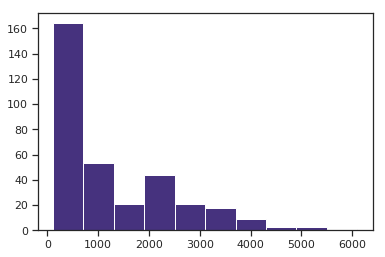

In [5]:
baseball.salary.hist(grid=False)

Since players salaries are strongly skewed, we will log-transform the response variable for the model.

In [6]:
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

For the purposes of this example, we will start the algorithm from 5 different starting positions in the model space $\Theta$, and will run each algorithm for 15 iterations.

In [7]:
nstarts = 5
iterations = 15

We will generate random starting candidate models by generating random indicators for each of the 27 predictors.

In [8]:
# Randomly initialize starting values of runs
runs = np.random.binomial(1, 0.5, ncols*nstarts).reshape((nstarts,ncols)).astype(bool)

As a measure of model parsimony, we will use Akaike's Information Criterion (AIC), which is an information-theoretic model selection criterion. It balances model fit (likelihood) with model size by penalizing the addition of parameters. 

\\[AIC = n \log(SSE/n) + 2k\\]

Thus models that add parameters that do not appreciably inrpove model fit will be down-weighted by AIC. Better models have a lower AIC value for a given dataset.

In [9]:
aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_

At each iteration of the algorithm, we examine models in the 1-neighborhood of the current model by adding or dropping each predictor in turn, fitting the model and calculating the associated AIC value. We then select the model with the lowest AIC in the neighborhood and set that to the current model.

In [10]:
from sklearn.linear_model import LinearRegression

runs_aic = np.empty((nstarts, iterations))

for i in range(nstarts):
    
    run_current = runs[i]
    
    for j in range(iterations):
        
        # Extract current set of predictors
        run_vars = predictors[predictors.columns[run_current]]
        g = LinearRegression().fit(X=run_vars, y=logsalary)
        run_aic = aic(g, run_vars, logsalary)
        run_next = run_current
        
        # Test all models in 1-neighborhood and select lowest AIC
        for k in range(ncols):
            run_step = run_current.copy()
            run_step[k] = not run_current[k]
            run_vars = predictors[predictors.columns[run_step]]
            g = LinearRegression().fit(X=run_vars, y=logsalary)
            step_aic = aic(g, run_vars, logsalary)
            if step_aic < run_aic:
                run_next = run_step.copy()
                run_aic = step_aic
            
        run_current = run_next.copy()
        runs_aic[i,j] = run_aic
        
    runs[i] = run_current
                

Plotting the change in AIC, we see that all the runs tend to converge to the same (or equivalent) models.

Text(0.5,0,'iteration')

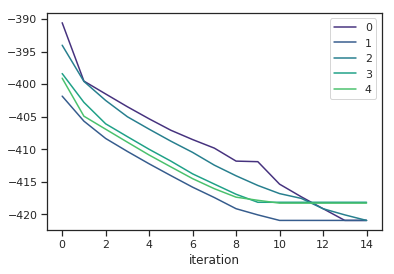

In [11]:
pd.DataFrame(runs_aic).T.plot(grid=False)
plt.xlabel('iteration')

This table shows the number of times a given predictor was used across all 5 solutions:

In [12]:
pd.Series(runs.sum(0), index=predictors.columns).sort_values(ascending=False)

arbitration     5
hitsperso       5
runs            5
rbis            5
sos             5
freeagent       5
runsperso       5
sbsobp          4
triples         3
sbsruns         3
average         3
soserrors       3
errors          2
obppererror     1
hitspererror    1
obp             1
sbshits         1
hrsperso        0
rbisperso       0
walksperso      0
sbs             0
runspererror    0
walks           0
homeruns        0
hrspererror     0
doubles         0
hits            0
dtype: int64

## Simulated Annealing

Annealing is a metallurgic process that involves heating a material beyond its critical temperature, maintaining a suitable temperature, and then cooling. If the process is followed according to a schedule appropriate to the material, annealing increases its ductility and reduces the number of defects. ***Simulated annealing*** uses an analogous process to pursue an optimial solution of a function over a large search space, in the sense that at high  "temperatures" (large probabilities) solutions are proposed from more distant regions of the  parameter space relative to the current solution. Similarly, "cooling" slowly reduces the number of exploratory proposals in order to converge on a (hopefully) global optimum. Thus, there is an initial period of liberal exploration, which gradually decreases to resemble hill-climbing procedures that we have already seen.

A generic simulated annealing algorithm proceeds as follows:

1. Initialize $t=0$, $\theta^{(t=0)}$, temperature $\tau^{(0)}$
2. Iterate until convergence:

    a. Select candidate solution $\theta^{\prime}$ from neighborhood of $\theta^{(t)}$ 
    according to proposal g($\theta^{(t)})$  
    b. Set $\theta^{(t+1)} = \theta^{\prime}$ with probability:
    
    $$\alpha = \min\left(1, \exp\left[\frac{f(\theta^{(t)})-f(\theta^{\prime})}{\tau^{(j)}}\right]\right)$$
    
    otherwise, set $\theta^{(t+1)} = \theta^{(t)}$  
    c. Repeat (a) and (b) for $m_j$ iterations  
    d. Increment $j$, update $\tau^{(j)}$ and $m_j$ according to cooling schedule
    
This algorithm can be halted once the minimum temperature is reached. The temerature $\tau^{(j)}$ should slowly decrease, while the time spent at each temperature $m_j$ should correspondingly increase.

Notice that this algorithm implies that though superior candidates are *always* adopted when proposed, inferior solutions are also accepted, but with some probability that is related to its quality relative to the current solution. This is what allows for exploration of the parameter space, and the escape from local optima.

### Proposals

A variety of proposal and neighborhood strategies can be effective, depending on the structure of the problem at hand. One constraint on generating proposed solutions is that all pairs of solutions $(\theta^{(i)}, \theta^{(j)}) \in \Theta, i \ne j$ be able to ***communicate***. That is, there must exist some finite sequence of solutions that can be generated starting at $\theta^{(i)}$ such that we eventually reach $\theta^{(j)}$.

The simplest example of a proposal strategy that allows for communication among solutions is to sample uniformly from the $k$-neighborhood of the current solution.

### Cooling and Convergence

Unlike some metaheuristics, the limiting behavior of simulated annealing is pretty well-known. Within each temperature regime, the SA algorithm produces a homogeneous Markov chain (since the transition probabilties do not change at each step), becoming non-homogeneous whenever a cooling event is triggered. If we generate symmetric proposals, such that the probability of proposing $\theta^{(i)}$ from $\theta^{(j)}$ is equal to that of proposing $\theta^{(j)}$ from $\theta^{(i)}$, then the *stationary* distribution of the Markov chain is:

$$p_{\tau}(\theta) \propto \exp[-f(\theta)/\tau]$$

So, in the limit, as we run the Markov chain, it converges to $p_{\tau}(\theta)$. During the SA algorithm, we want to run the chain long enough so that it is close to its stationary distribution before cooling. How long is "long enough" usually takes some experimentation using trial runs.

In general, we adopt a cooling schedule that sets the temperature at period $j$ according to $\tau^{(j)} = f_{\alpha}(\tau^{(j-1)})$ and the number of iterations in period $j$ according to $m_j = f_\beta(m_{j-1})$. Some specific examples include:

* $m_j = 1$ for all $j$, with very slow cooling via $\tau^{(j)} = \tau^{(j-1)}/( 1 + \alpha \tau^{(j-1)})$ for some small chosen $\alpha$
* $\tau^{(j)} = \alpha \tau^{(j-1)}$ for some $\alpha \lt 1$ with $m_j = \beta m_{j-1}$ for some $\beta \lt 1$

One approach is to choose an initial temperature $\tau^{(0)}$ so that $p$ is close to 1 for all combinations of $\theta^{(i)}$ and $\theta^{(j)}$, which provides any point a reasonable chance of being visited early in the simulation. 

The appropriate choice for $m_j$ is a tradeoff between performance and speed: a large number of steps can produce a more accurate solution, but requires additional computation. Evidence suggests that long runs at high temperatures is not optimal. For most problems, good cooling schedules invlove a rapid decrease in temperature early in the simulation.

### Example: Baseball salaries

Let's revisit the baseball salaries example, this time using simulated anealling to search for an optimal model:

In [13]:
tau_start = 10
# cooling_schedule = [tau_start]*60 + [tau_start/2]*120 + [tau_start/10]*240
cooling_schedule = [tau_start*0.99**i for i in range(400)]
aic_values = []

Initialize the annealing run and temperature schedule:

In [14]:
solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
solution_vars = predictors[predictors.columns[solution_current]]
g = LinearRegression().fit(X=solution_vars, y=logsalary)
aic_best = aic(g, solution_vars, logsalary)
aic_values.append(aic_best)

Here is the simulated annealing run:

In [15]:
for tau in cooling_schedule:
        
    # Random change 1-neighborhood
    flip = np.random.randint(0, ncols)
    solution_current[flip] = not solution_current[flip]
    solution_vars = predictors[predictors.columns[solution_current]]
    g = LinearRegression().fit(X=solution_vars, y=logsalary)
    aic_step = aic(g, solution_vars, logsalary)
    alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau))

    if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
        # Accept proposed solution
        aic_values.append(aic_step)
        if aic_step < aic_best:
            # Replace previous best with this one
            aic_best = aic_step
            solution_best = solution_current.copy()
    else:
        # Revert solution
        solution_current[flip] = not solution_current[flip]
        aic_values.append(aic_values[-1])

Best AIC: -418.6118886471737
Best solution: (array([ 2,  5,  7,  9, 12, 13, 19, 20, 21, 23, 24]),)
Discovered at iteration 305


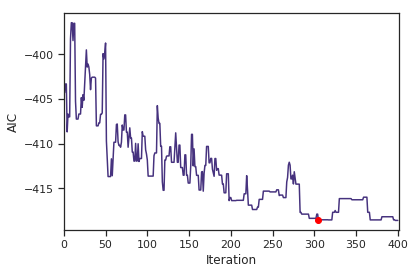

In [16]:
plt.plot(aic_values)
plt.xlim(0, len(aic_values))
plt.xlabel('Iteration')
plt.ylabel('AIC')
print('Best AIC: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(aic_best, 
            np.where(solution_best==True),
            np.where(aic_values==aic_best)[0][0]))
plt.plot(np.where(aic_values==aic_best)[0][0], aic_best, 'ro')

We can compare this solution to one of the local search results:

In [17]:
np.where(runs[-1]==True)

(array([ 1,  2,  7,  9, 11, 12, 13, 14, 15, 24, 26]),)

### Exercise

Create a function for simulated annealing that uses the above code, but allows for custom cooling schedules (and other parameters) to be passed. Try running the function with the continuous cooling schedule (e.g. cooling by 10% each iteration) described above and comapare the results to the one above.

In [18]:
# Write your answer here

## Genetic Algorithms

From a metallurgic metaphor, we turn to an ecological one: The genetic algorithm (GA) metaheuristic mimics the process of natural selection. In doing so, we construct a **population** of solutions that are analogous to organisms in a natural system. The relative quality of any particular solution represents its fitness, and improves its ability to pass on its desirable attributes to future generations of solutions, which are generated by combining with other viable solutions.

Phenotypes in GA are candidate solutions, the components of which are coded into its genotype on the chromosome. For convenience, organisms in GA have a single chromosome. If we take our baseball salary problem as an example, the chromosome might simply consist a list of indicators for the presence of each available covariate in a particular model:

    [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 
    1, 1, 1, 0, 1, 1, 0, 0]
    
this particular chromosome encodes for a model with `runs, triples, rbis, sos, freeagent, arbitration, obppererror, runspererror, hitspererror, soserrors, sbsobp` included as covariates. Thus, each locus on the chromosome is a linear model coefficient, and the two corresponding alleles are the presence and absence of that coefficient.

*How would you encode the travelling salesman problem?*

The key aspect of the natural selection metaphor is the concept of ***fitness***. In nature, individuals with high fitness are those who are able to pass their genes onto the next generation more successfully than other individuals in the population; typically, this relates both to the ability to survive to reproductive age, and then to reproduce successfuly. In a genetic algorithm, "fit" individuals are solutions of high value, as determined by our objective function of choice; for the baseball salary example we have been using, this is the AIC value of the linear model corresponding to the candidate solution. We facilitate this in the algorithm by giving high-value solutions a higher probability of propagating into the next generation than those of low probability.

Let's consider another genotype,

    [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 
    0, 1, 1, 1, 1, 0, 1, 0]
    
Comparing this with the previous genotype, we say that the ***schema*** for this set of two genotypes is:

    [0, 0, 1, 0, *, 1, 0, *, 0, 1, 0, 0, 1, 1, *, 0, *, *, 0, 
    *, 1, 1, *, 1, *, *, 0]
    
where wildcards (`*`) represent loci that differ among the set. If this schema (or aspects of it) confer higher fitness, then it will tend to be represented in future populations as the algorithm progresses.

The key difference between GA and previous metaheuristics is that here we track more than one candidate solution simultaneously, in the form of our "population" of organisms, each of which encodes a solution. This population changes over time as organisms reproduce, via ***crossover*** and ***mutation***.

### Reproduction and Genetic Change

In a genetic algorithm, individual solutions "reproduce" by combining with other solutions in the population according to some rule that is fitness-based. For example, we may select pairs of parent solutions with probabilities proportional to their fitness, and combine them to generate child solutions, which replace their parents in the next generation.

There are a handful of ***genetic operators*** that are used to create children from parents. The first is crossover, which randomly allocates a position on two parent chromosomes after which all the genes on the two chromosomes swap from one to the other. For example, let's arbitrarily specify a crossover after position 7 of a pair of 10-gene chromosomes (here indicated by an apostrophe):


    0100101`001
    
    0001001`111
    
This would result in two new genotypes in the offspring of these parents:


    0100101111
    
    0001001001
    
Notice that the schema from the two chromosomes (`0*0***01**1`) is preserved in the next generation.

One way to escape the constraint of schema preservation is to apply a second genetic operator, mutation. Mutation is usually applied after crossover, and simply involves randomly changing an allele at a randomly-chosen locus, according to some specified mutation rate. Note that if mutation is too rare it reduces the rate at which the solution space is explored, and if too frequent it disrupts the inheritance of high-value schema.

In [19]:
pop_size = 20
iterations = 100
mutation_rate = .02

In [20]:
aic_best = []
best_solution = []
aic_history = []

First, we initialize the population, and their corresponding fitness.

In [21]:
# Initialize genotype
current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))

In [22]:
def calculate_fitness(aic_values):
    P = len(aic_values)
    aic_rank = (-aic_values).argsort().argsort()+1.
    return 2.*aic_rank/(P*(P+1.))

In [23]:
for i in range(iterations):
    
    # Get phenotype
    current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
    # Calculate AIC
    current_aic = np.array([aic(LinearRegression().fit(X=x, y=logsalary), x, logsalary) for x in current_phe])
    # Get lowest AIC
    aic_best.append(current_aic[np.argmin(current_aic)])
    best_solution.append(current_gen[np.argmin(current_aic)])
    
    # Calculate fitness according to AIC rank
    fitness = calculate_fitness(current_aic)
    
    # Choose first parents according to fitness
    moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
    # Choose second parents randomly
    dads = np.random.choice(range(pop_size), size=int(pop_size/2))
    
    next_gen = []
    for x,y in zip(current_gen[moms], current_gen[dads]):
        # Crossover
        cross = np.random.randint(0, ncols)
        child1 = np.r_[x[:cross], y[cross:]]
        child2 = np.r_[y[:cross], x[cross:]]
        # Mutate
        m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
        child1[m1] = abs(child1[m1]-1)
        m2 = np.random.binomial(1, mutation_rate, size=ncols)
        child2[m2] = abs(child1[m2]-1)
        next_gen += [child1, child2]
        
    # Increment generation
    current_gen = np.array(next_gen)
    # Store AIC values
    aic_history.append(current_aic)

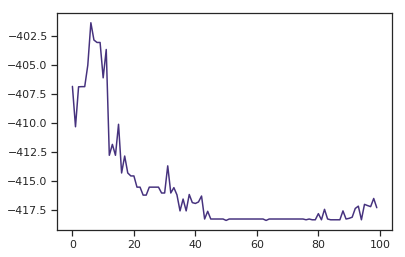

In [24]:
plt.plot(aic_best)

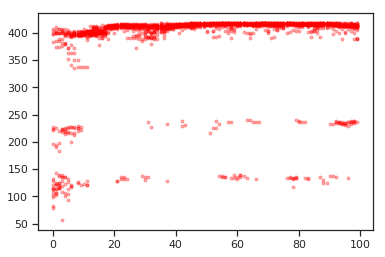

In [25]:
for i,x in enumerate(aic_history):
    plt.plot(np.ones(len(x))*i, -x, 'r.', alpha=0.3)

## Exercise: Wine classification

Thirteen chemical measurements were carried out on each of 178 wines from three regions of Italy. These data are available in the `wine.dat` file in your `data` directory. Using one or more heuristic search methods from this lecture, partition the wines into three groups for which the total of the within-group sum of squares is minimal.

In [26]:
# Write your answer here

In [27]:
wine = pd.read_table('../data/wine.dat', sep='\s+')
grape = wine.pop('region')
# wine = wine.iloc[:,[2,5,7,9,11]]
nrows, ncols = wine.shape

In [28]:
ncols

13

In [29]:
def ss(x):
    return np.sum((x - x.mean())**2).sum()

In [30]:
def within_ss(assignment):
    return sum(ss(wine[solution_current==i]) for i in range(3))

In [31]:
tau_start = 10000
# cooling_schedule = [tau_start]*60 + [tau_start/2]*120 + [tau_start/10]*240
cooling_schedule = [tau_start*0.99**i for i in range(1000)]
ss_values = []

In [32]:
solution_current = solution_best = np.random.randint(0, 3, nrows)
ss_best = ss_current = within_ss(solution_current)
ss_values.append(ss_best)

In [33]:
within_ss(solution_current)

2267.6985009416194

In [34]:
for tau in cooling_schedule:
        
    # Random change 1-neighborhood
    change = np.random.randint(0, nrows)
    solution_step = solution_current.copy()
    solution_step[change] = np.random.randint(0, 3)
    ss_current = within_ss(solution_step)
    alpha = min(1, np.exp((ss_values[-1] - ss_current)/tau))
    if ((ss_current < ss_values[-1]) or (np.random.uniform() < alpha)):
        # Accept proposed solution
        ss_values.append(ss_current)
        solution_current = solution_step
        if ss_current < ss_best:
            
            # Replace previous best with this one
            ss_best = ss_current
            solution_best = solution_step.copy()
            
    else:
        ss_values.append(ss_values[-1])

Best SS: 2257.0028008217596
Best solution: [2 0 1 1 2 0 2 1 1 1 1 1 0 2 2 2 1 1 1 2 1 1 0 2 2 2 0 1 2 1 1 0 2 1 0 0 1
 1 0 2 1 0 1 2 2 1 1 1 1 0 2 1 1 0 2 2 1 1 1 2 2 1 1 1 1 0 2 2 2 2 1 1 0 0
 0 2 1 2 2 0 0 0 2 2 0 1 1 0 2 0 1 0 1 1 0 2 0 0 2 0 2 2 2 0 2 0 1 1 0 2 2
 0 2 1 0 0 2 2 0 0 0 1 0 0 1 2 0 1 1 0 2 1 2 0 1 2 1 0 1 1 2 1 0 2 1 1 1 0
 2 0 2 2 0 0 2 2 0 0 2 2 2 2 2 1 0 1 0 1 0 0 2 0 1 0 2 1 1 2]
Discovered at iteration 74


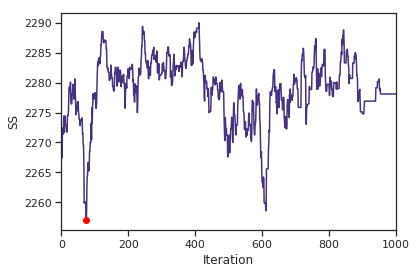

In [35]:
plt.plot(ss_values)
plt.xlim(0, len(ss_values))
plt.xlabel('Iteration')
plt.ylabel('SS')
print('Best SS: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(ss_best, 
            solution_best,
            np.where(ss_values==ss_best)[0][0]))
plt.plot(np.where(ss_values==ss_best)[0][0], ss_best, 'ro')

---
## References

Chapter 3 of [Givens, Geof H.; Hoeting, Jennifer A. (2012-10-09). Computational Statistics (Wiley Series in Computational Statistics)](http://www.stat.colostate.edu/computationalstatistics/)